In [1]:
import pandas as pd
from orion import Orion
from utils import plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

In [17]:
data = pd.read_csv('data/543341.csv', usecols=['Date', 'No. of Trades'], parse_dates=['Date'])
data.rename(columns={'No. of Trades': 'value', 'Date': 'timestamp'}, inplace=True)
data.sort_values(by='timestamp', inplace=True)
data.timestamp = (data.timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
data.head()

,timestamp,value
244,1647302400,3
243,1648166400,1
242,1648425600,1
241,1648512000,2
240,1648598400,2


In [18]:
known_anomalies = pd.DataFrame({
    'start': [1650997800],
    'end': [1661970599]
})

In [19]:
known_anomalies

,start,end
0,1650997800,1661970599


## Arima

In [5]:
result = adfuller(data['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -3.721728
p-value: 0.003818
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
Reject Ho - Time Series is Stationary


<AxesSubplot:>

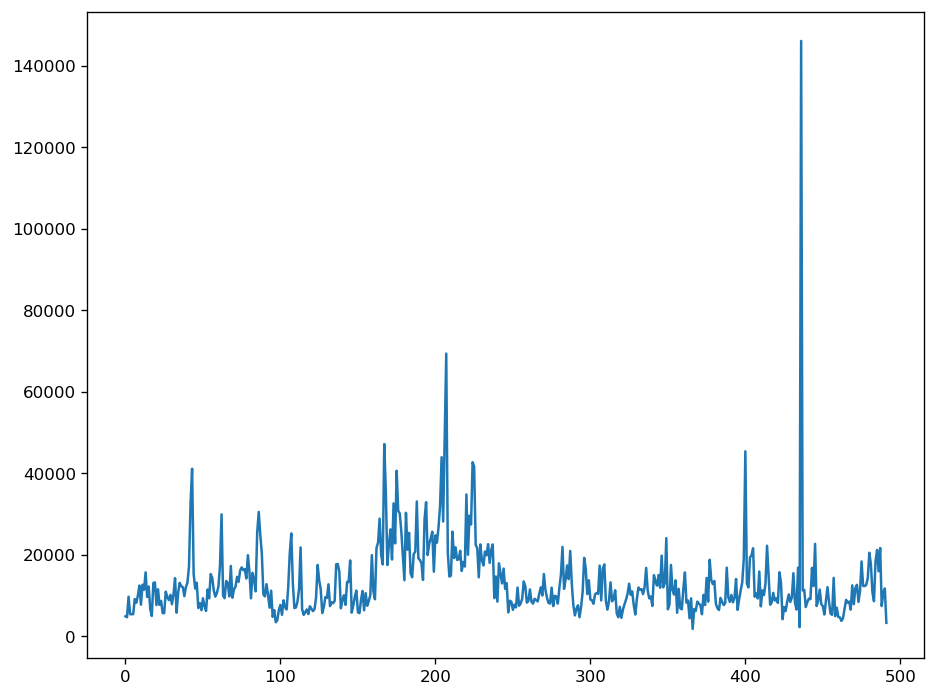

In [3]:
data['value'].plot()

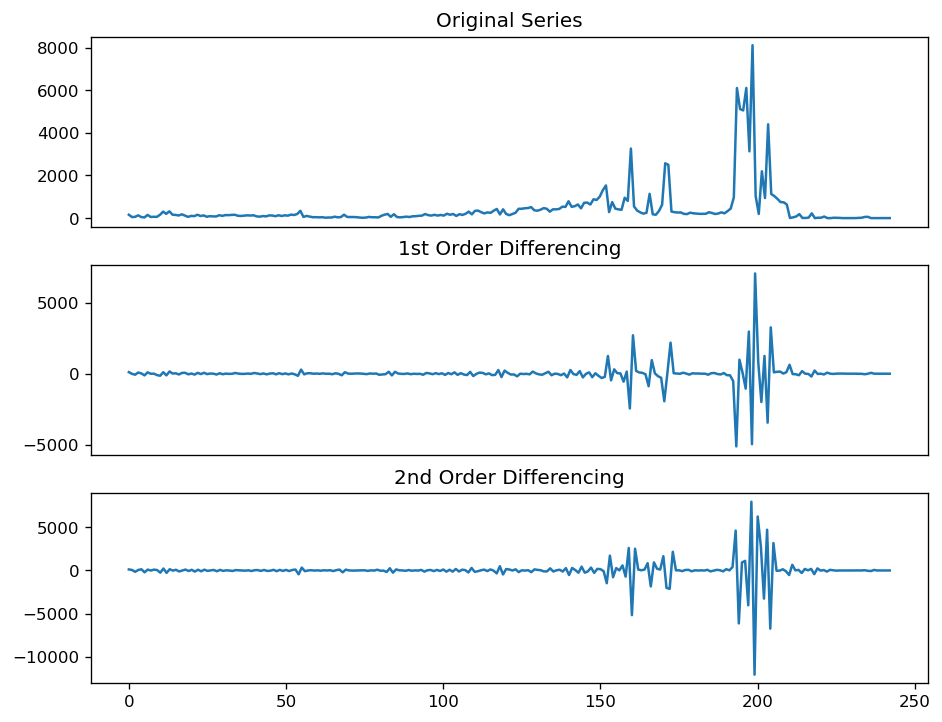

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data.value); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
ax2.plot(data.value.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
ax3.plot(data.value.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

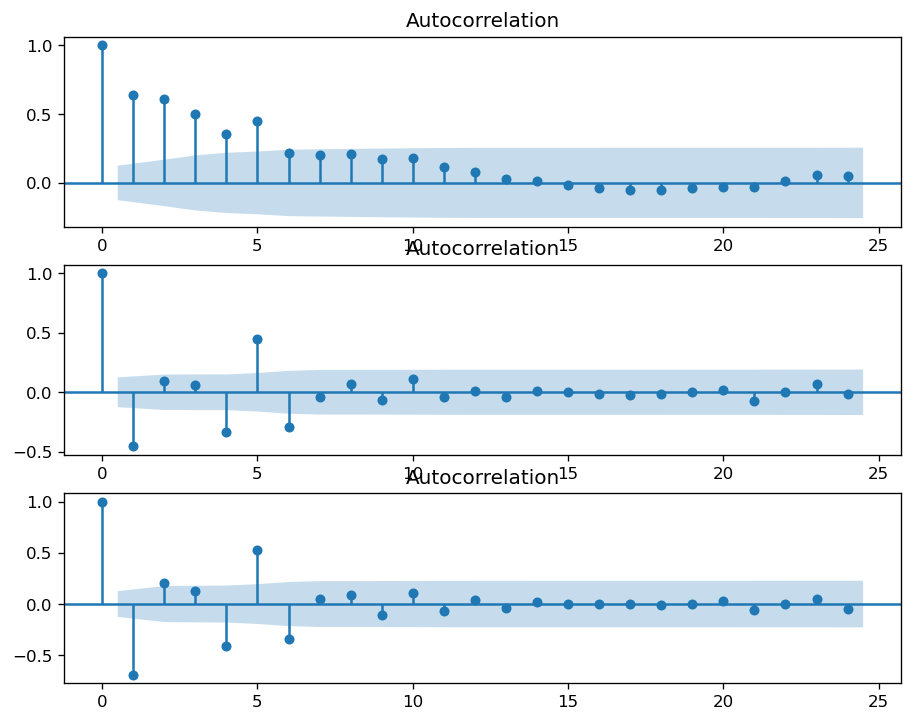

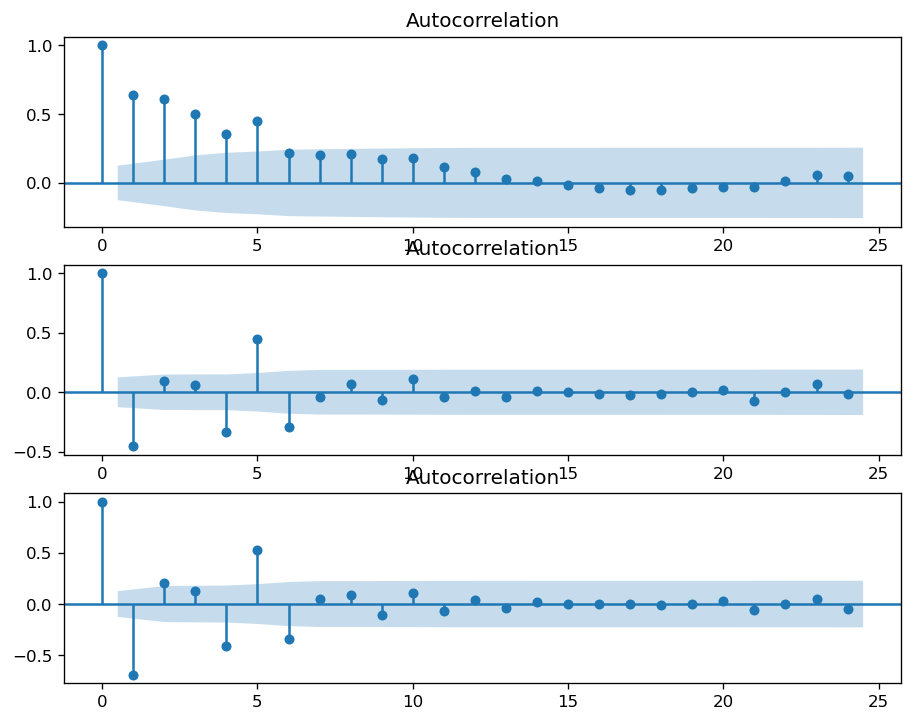

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data.value, ax=ax1)
plot_acf(data.value.diff().dropna(), ax=ax2)
plot_acf(data.value.diff().diff().dropna(), ax=ax3)

In [52]:
orion = Orion(
    'arima.json',
)

In [53]:
anomalies = orion.fit_detect(data)

/home/opc/.conda/envs/orion/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/opc/.conda/envs/orion/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to 

In [54]:
anomalies

,start,end,severity
0,1651320000,1654171200,2.077938


/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


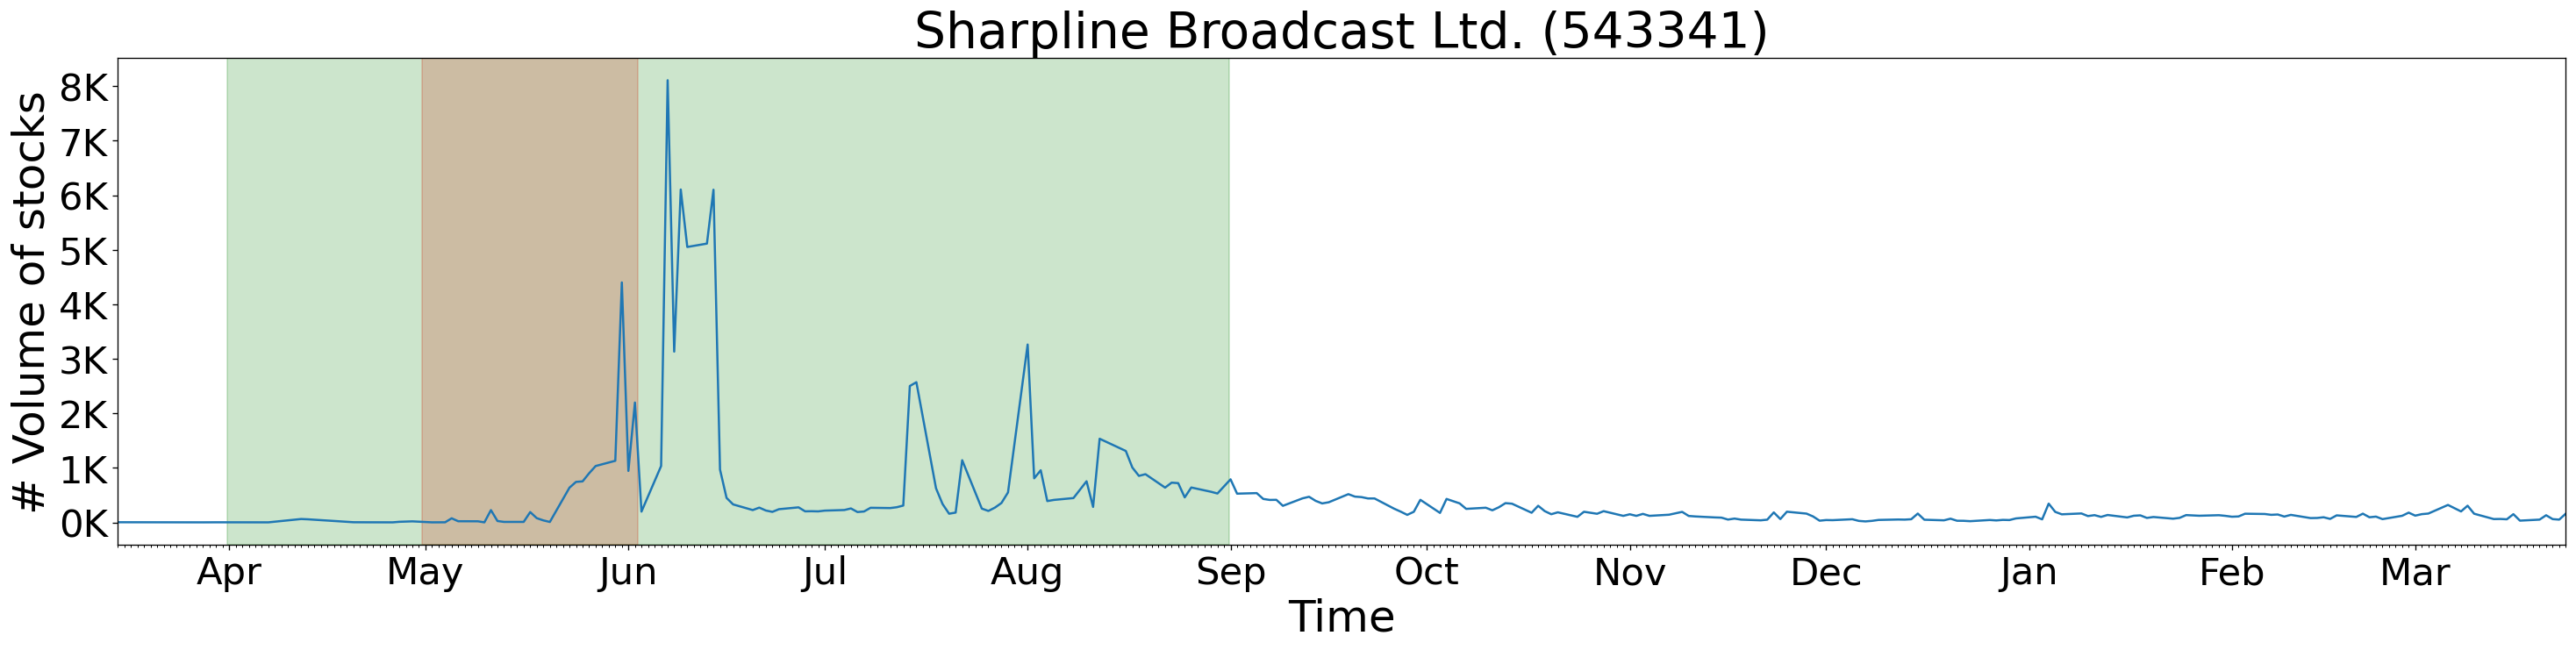

In [55]:
plot(data, 'Sharpline Broadcast Ltd. (543341)' ,[anomalies, known_anomalies])

In [56]:
orion.evaluate(data=data, ground_truth=known_anomalies)

/home/opc/.conda/envs/orion/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/opc/.conda/envs/orion/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to 

accuracy     0.679144
f1           0.354839
recall       0.215686
precision    1.000000
dtype: float64

## LSTM Autoencoder

In [20]:
hyperparameters = {
    "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences#1": {
        'target_column': 0,
        'window_size': 100
    },
    'keras.Sequential.LSTMSeq2Seq#1': {
        'epochs': 50,
        'verbose': True,
        'window_size': 100,
        'input_shape': [100, 1],
        'target_shape': [100, 1]
    }
}

In [21]:
orion = Orion(
    pipeline='lstm_autoencoder',
    hyperparameters=hyperparameters
)

In [22]:
#Slice data after timestamp 1396290500 and before 1426963000
data_t = data[(data.timestamp > 1640975400) & (data.timestamp < 1672511399)]

In [23]:
anomalies = orion.fit_detect(data_t)

Epoch 1/50
14/14 [==============================] - 2s 169ms/step - loss: 0.2452 - mse: 0.2452 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 2/50
14/14 [==============================] - 2s 116ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 3/50
14/14 [==============================] - 2s 121ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 4/50
14/14 [==============================] - 2s 135ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 5/50
14/14 [==============================] - 2s 141ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 6/50
14/14 [==============================] - 2s 133ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 7/50
14/14 [==============================] - 2s 118ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 8/50
14/14 [==============================] - 2s 125ms/step - loss: 0.

In [24]:
anomalies

,start,end,severity
0,1653566400,1656266400,0.763206
1,1656676800,1660500000,0.348582


In [25]:
orion.evaluate(data=data_t, ground_truth=known_anomalies)

17/17 [==============================] - 1s 36ms/step


accuracy     0.822414
f1           0.745679
recall       0.594488
precision    1.000000
dtype: float64

/home/opc/.conda/envs/orion/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


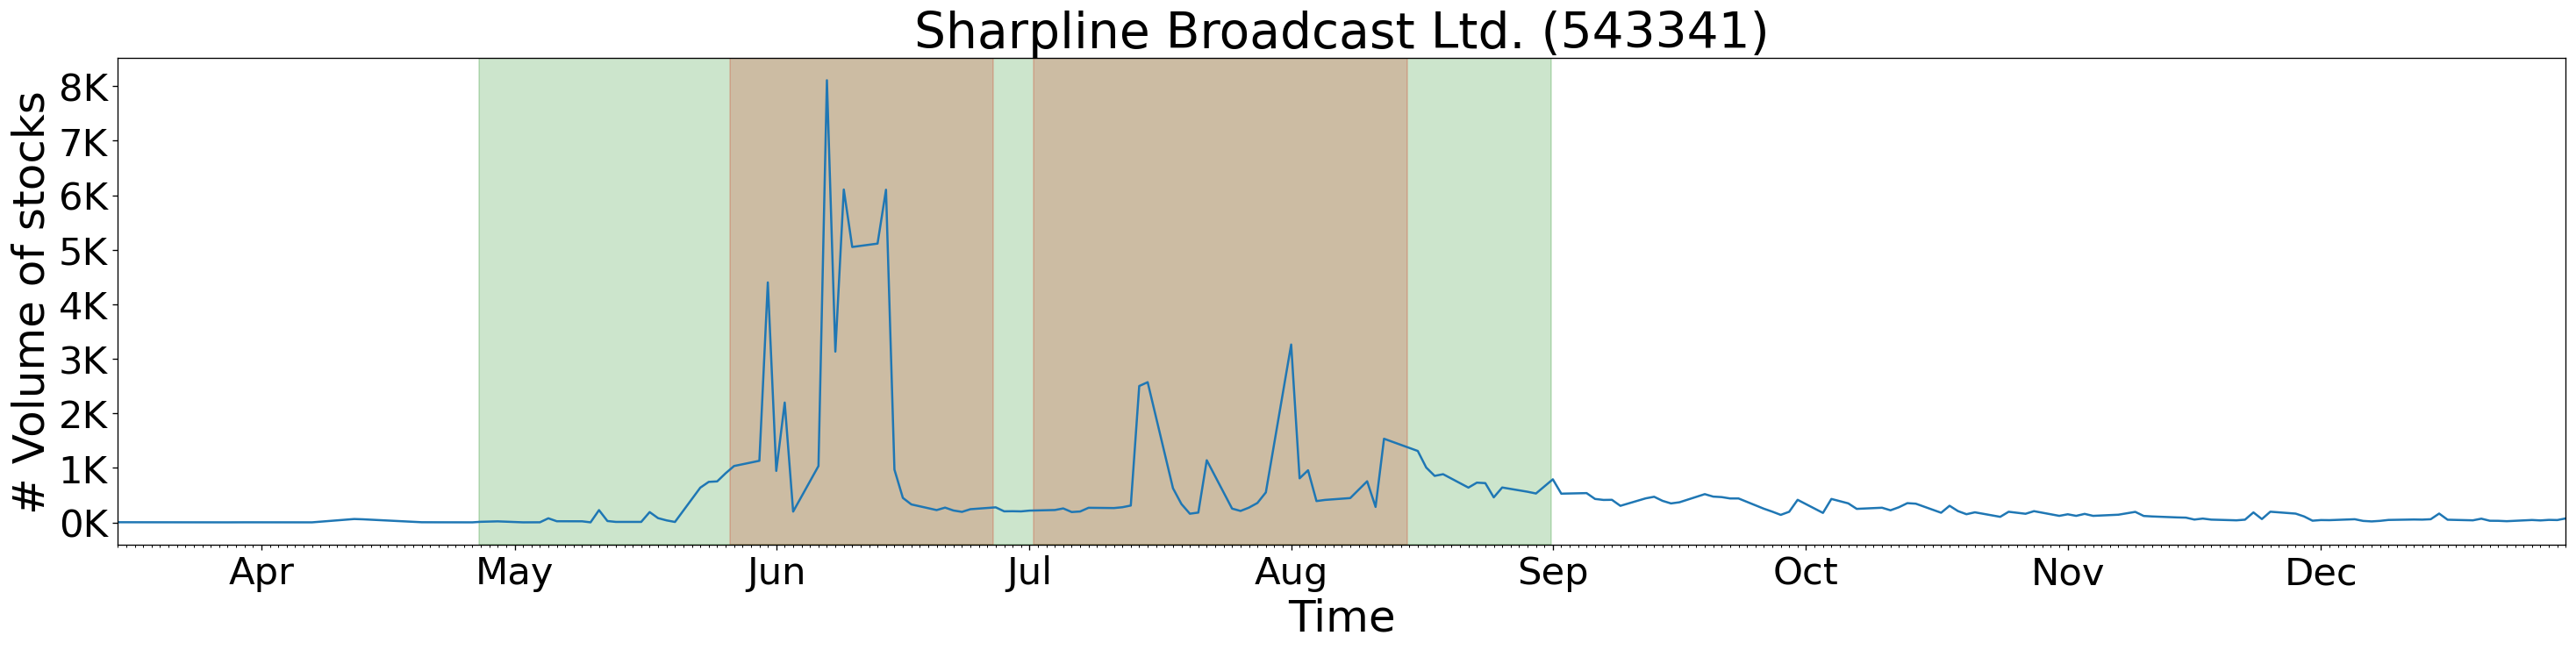

In [26]:
plot(data_t, 'Sharpline Broadcast Ltd. (543341)' ,[anomalies, known_anomalies])

## LSTM with Dynamic Thresholding

In [30]:
hyperparameters = {
    "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences#1": {
        'target_column': 0,
        'window_size': 250
    },
    'keras.Sequential.LSTMTimeSeriesRegressor#1': {
        'epochs': 50,
        'verbose': True,
        'window_size': 250,
        'input_shape': [250, 1],
        'target_shape': [250, 1]
    }
}

In [31]:
orion = Orion(
    pipeline='lstm_dynamic_threshold',
    hyperparameters=hyperparameters
)

In [32]:
anomalies = orion.fit_detect(data_t)

Epoch 1/50
12/12 [==============================] - 5s 389ms/step - loss: 0.1691 - mse: 0.1691 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 2/50
12/12 [==============================] - 4s 354ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 3/50
12/12 [==============================] - 4s 360ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 4/50
12/12 [==============================] - 4s 351ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/50
12/12 [==============================] - 4s 347ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 6/50
12/12 [==============================] - 4s 344ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 7/50
12/12 [==============================] - 4s 345ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/50
12/12 [==============================] - 4s 342ms/step - loss: 0.

In [36]:
anomalies

,start,end,severity
0,1654711200,1656244800,0.217188
1,1656763200,1661342400,0.451337


/home/opc/.conda/envs/orion/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


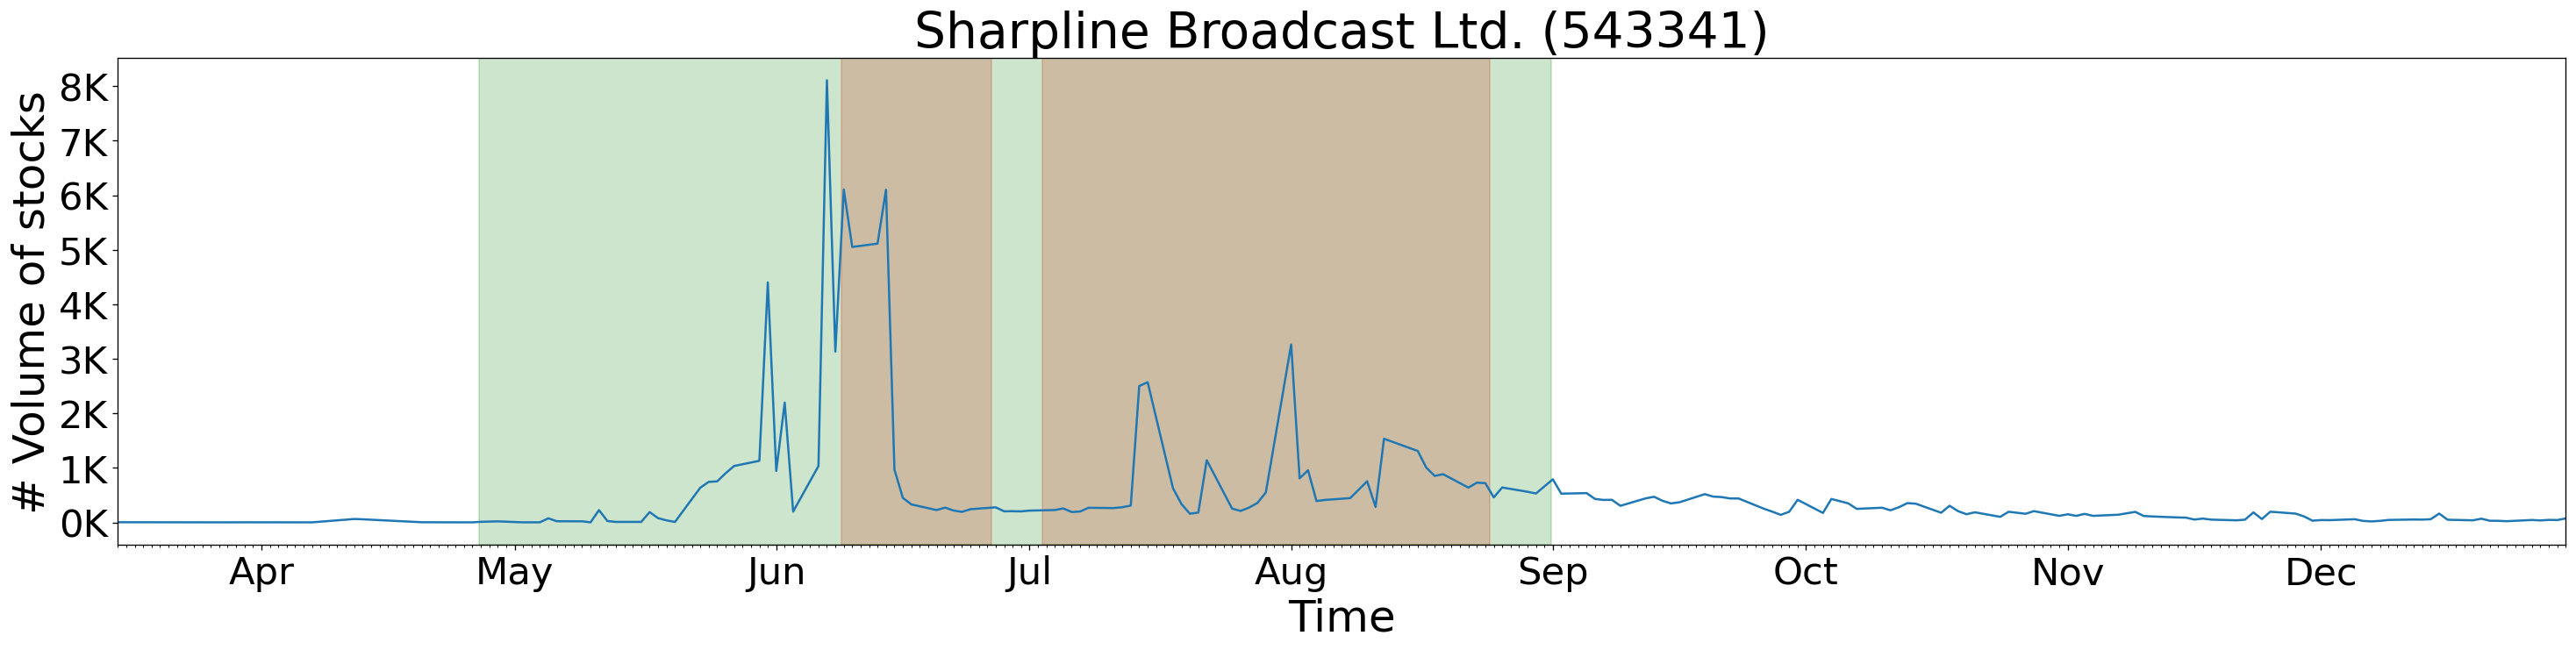

In [37]:
plot(data_t, 'Sharpline Broadcast Ltd. (543341)' ,[anomalies, known_anomalies])

In [35]:
orion.evaluate(data=data, ground_truth=known_anomalies)

20/20 [==============================] - 2s 109ms/step


accuracy     0.891711
f1           0.810305
recall       0.681103
precision    1.000000
dtype: float64

## TadGAN

In [38]:
parameters = {
  'mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate#1': {
    "interval": 3600,
  },

}

In [39]:
orion = Orion(
    'tadgan.json',
    parameters
)

In [40]:
anomalies = orion.fit_detect(data_t)

Epoch: 1/15, Losses: {'cx_loss': -5.503, 'cz_loss': 1.5063, 'eg_loss': -2.3132}
Epoch: 2/15, Losses: {'cx_loss': -0.5742, 'cz_loss': -14.5055, 'eg_loss': 21.82}
Epoch: 3/15, Losses: {'cx_loss': -1.48, 'cz_loss': 2.4977, 'eg_loss': 11.9614}
Epoch: 4/15, Losses: {'cx_loss': -1.6616, 'cz_loss': -10.514, 'eg_loss': 25.8137}
Epoch: 5/15, Losses: {'cx_loss': 1.5685, 'cz_loss': -2.5109, 'eg_loss': -83.1866}
Epoch: 6/15, Losses: {'cx_loss': -1.3709, 'cz_loss': 1.3892, 'eg_loss': -104.75}
Epoch: 7/15, Losses: {'cx_loss': -1.2903, 'cz_loss': 0.6048, 'eg_loss': -93.8879}
Epoch: 8/15, Losses: {'cx_loss': -1.6338, 'cz_loss': 0.9021, 'eg_loss': -90.86}
Epoch: 9/15, Losses: {'cx_loss': -1.7097, 'cz_loss': 1.5937, 'eg_loss': -92.8056}
Epoch: 10/15, Losses: {'cx_loss': -2.1819, 'cz_loss': 1.786, 'eg_loss': -89.3781}
Epoch: 11/15, Losses: {'cx_loss': -2.4526, 'cz_loss': 2.4095, 'eg_loss': -91.9024}
Epoch: 12/15, Losses: {'cx_loss': -2.9681, 'cz_loss': 1.5986, 'eg_loss': -74.9558}
Epoch: 13/15, Losses: {

In [41]:
anomalies

,start,end,severity
0,1654441200,1655352000,1.153792
1,1657562400,1658070000,0.762262
2,1659042000,1659618000,0.902619
3,1660550400,1660928400,0.140382


/home/opc/.conda/envs/orion/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


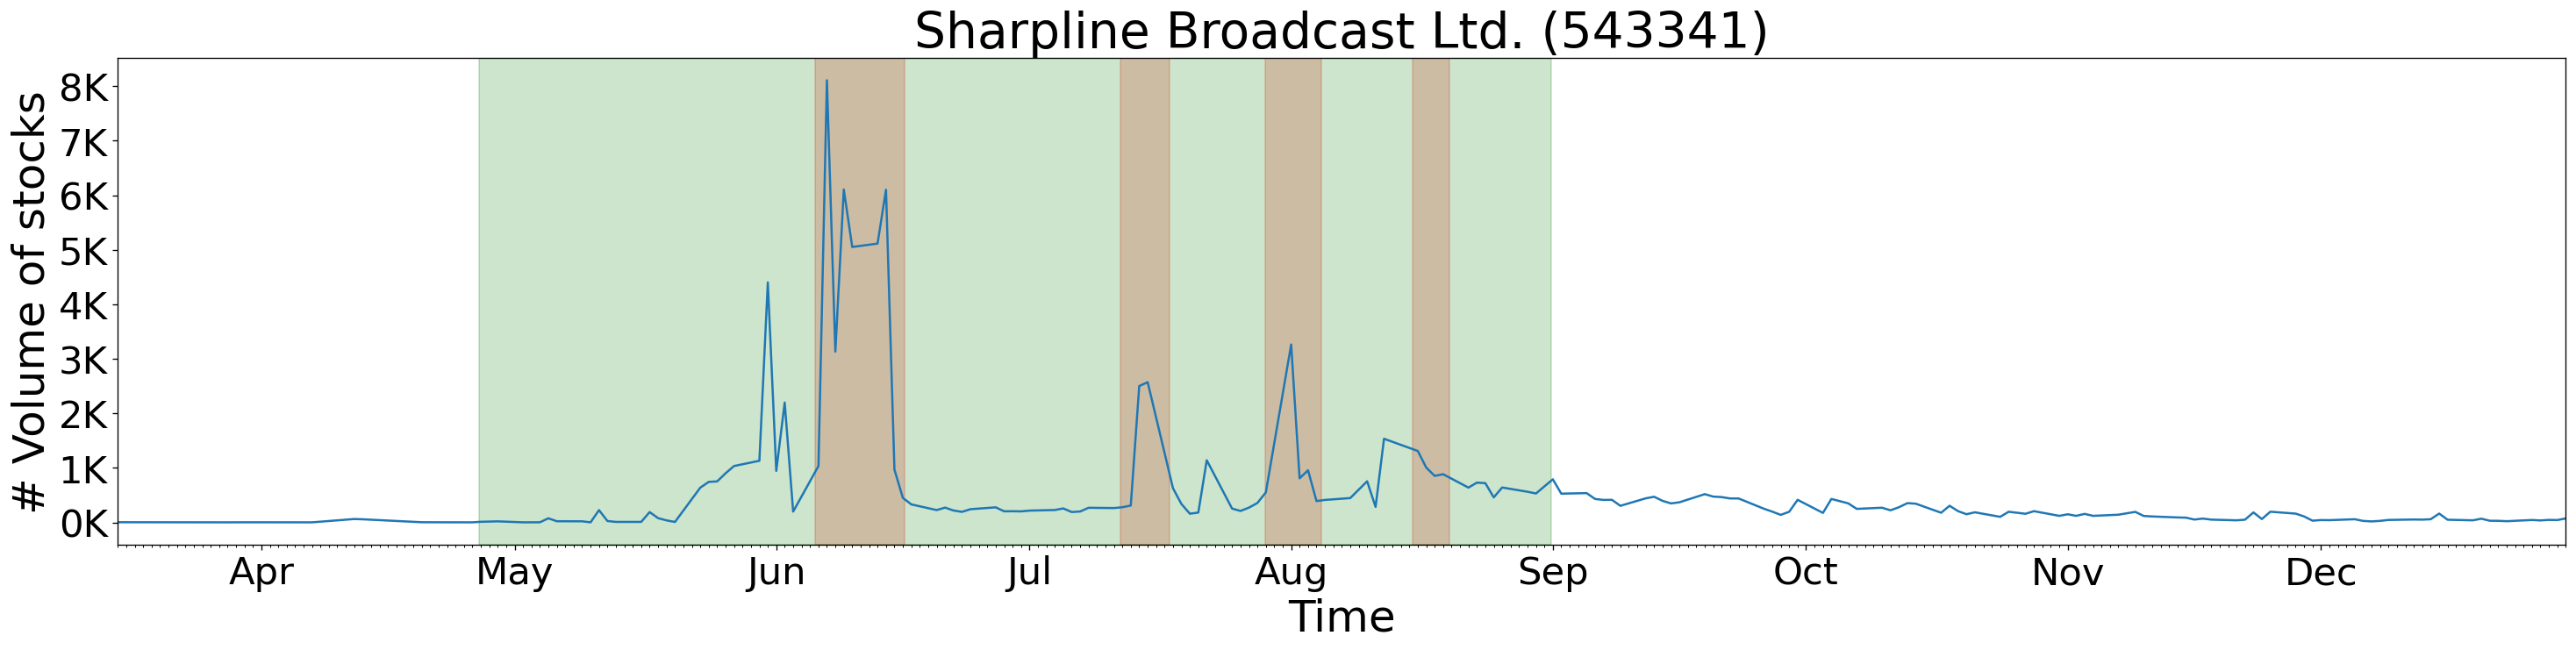

In [42]:
plot(data_t, 'Sharpline Broadcast Ltd. (543341)' ,[anomalies, known_anomalies])

In [66]:
orion.evaluate(data=data, ground_truth=known_anomalies)

accuracy     0.915960
f1           0.229243
recall       0.150212
precision    0.483761
dtype: float64

## AER

In [43]:
orion = Orion(
    'aer.json'
)

In [44]:
anomalies = orion.fit_detect(data_t)

Epoch 1/50
14/14 [==============================] - 3s 210ms/step - loss: 0.2448 - tf_op_layer_strided_slice_6_loss: 0.2960 - tf_op_layer_strided_slice_7_loss: 0.2377 - tf_op_layer_strided_slice_8_loss: 0.2077 - val_loss: 0.0754 - val_tf_op_layer_strided_slice_6_loss: 0.0357 - val_tf_op_layer_strided_slice_7_loss: 0.1310 - val_tf_op_layer_strided_slice_8_loss: 0.0040
Epoch 2/50
14/14 [==============================] - 2s 136ms/step - loss: 0.0641 - tf_op_layer_strided_slice_6_loss: 0.1042 - tf_op_layer_strided_slice_7_loss: 0.0434 - tf_op_layer_strided_slice_8_loss: 0.0654 - val_loss: 0.0487 - val_tf_op_layer_strided_slice_6_loss: 0.1041 - val_tf_op_layer_strided_slice_7_loss: 0.0048 - val_tf_op_layer_strided_slice_8_loss: 0.0813
Epoch 3/50
14/14 [==============================] - 2s 135ms/step - loss: 0.0527 - tf_op_layer_strided_slice_6_loss: 0.0688 - tf_op_layer_strided_slice_7_loss: 0.0409 - tf_op_layer_strided_slice_8_loss: 0.0600 - val_loss: 0.0379 - val_tf_op_layer_strided_slice

/home/opc/.conda/envs/orion/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


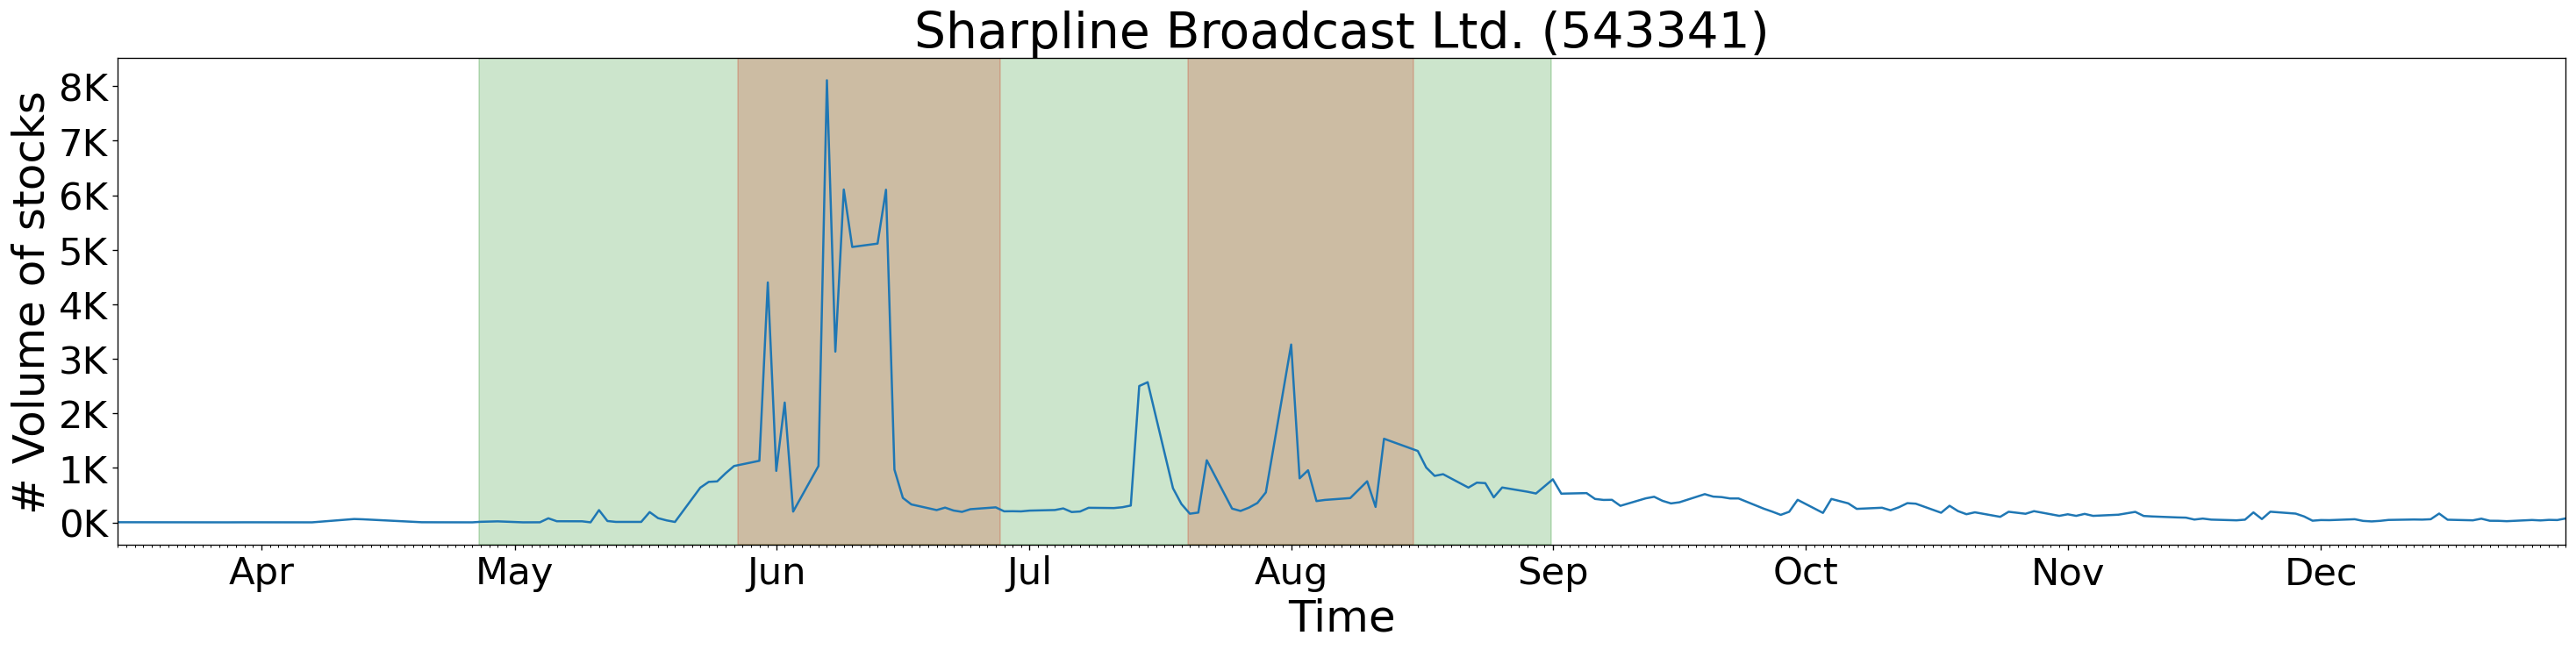

In [45]:
plot(data_t, 'Sharpline Broadcast Ltd. (543341)' ,[anomalies, known_anomalies])

In [16]:
orion.evaluate(data=data_t, ground_truth=known_anomalies)

accuracy     0.741690
f1           0.577577
recall       0.406051
precision    1.000000
dtype: float64

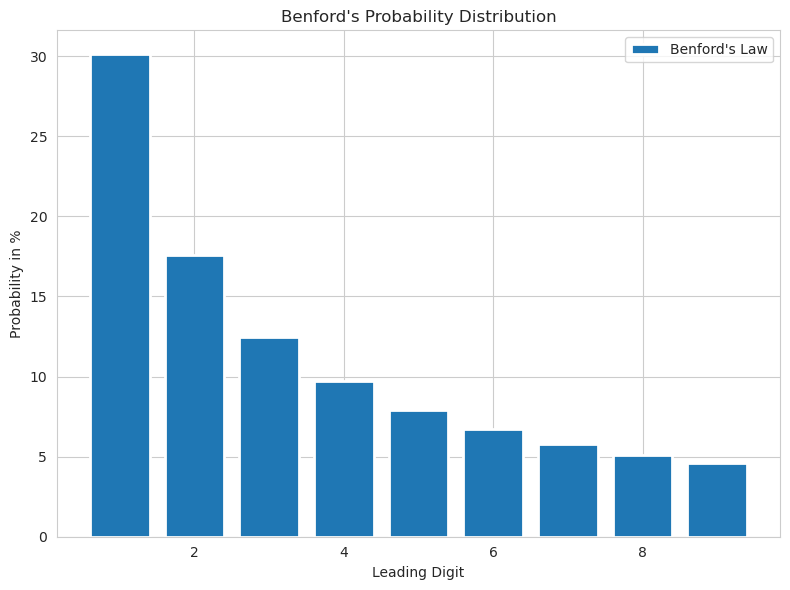

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def benfords_law():
    # Initialize a list to store the frequency of each digit (1-9)
    digit_frequencies = [0] * 9
    
    # Read the data from a file or generate your own data
    # For demonstration purposes, let's generate random numbers
    data = np.random.uniform(1, 1000, 1000)
    
    # Iterate through each data point
    for num in data:
        first_digit = int(str(num)[0])  # Get the first digit of the number
        
        # Increment the frequency of the corresponding digit
        digit_frequencies[first_digit - 1] += 1
        
    # Calculate the total count
    total_count = sum(digit_frequencies)
    
    # Calculate the expected Benford's Law frequencies
    benfords_frequencies = [np.log10(1 + (1 / digit)) * total_count for digit in range(1, 10)]
    log_frequencies = [np.log(digit_frequency) for digit_frequency in digit_frequencies]
    benfords_frequencies = [frequency/10 for frequency in benfords_frequencies]
    
    # Plot the results using seaborn
    digits = range(1, 10)
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 6))
    plt.bar(digits, benfords_frequencies, label="Benford's Law", linewidth=2)
    plt.xlabel('Leading Digit')
    plt.ylabel('Probability in %')
    plt.title("Benford's Probability Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to generate the graph
benfords_law()


/tmp/ipykernel_896748/853952884.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(digits, benfords_frequencies, 'r-', label="Benford's Law", linewidth=2, marker='o', markersize=6, color='salmon')
/tmp/ipykernel_896748/853952884.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


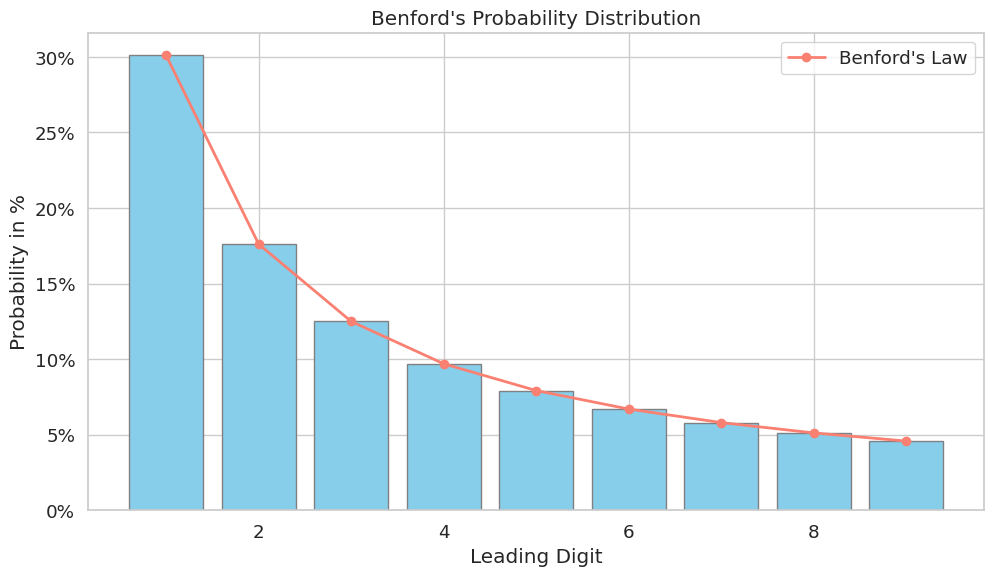

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def benfords_law():
    # Initialize a list to store the frequency of each digit (1-9)
    digit_frequencies = [0] * 9
    
    # Read the data from a file or generate your own data
    # For demonstration purposes, let's generate random numbers
    data = np.random.uniform(1, 1000, 1000)
    
    # Iterate through each data point
    for num in data:
        first_digit = int(str(num)[0])  # Get the first digit of the number
        
        # Increment the frequency of the corresponding digit
        digit_frequencies[first_digit - 1] += 1
        
    # Calculate the total count
    total_count = sum(digit_frequencies)
    
    # Calculate the expected Benford's Law frequencies
    benfords_frequencies = [np.log10(1 + (1 / digit)) * total_count for digit in range(1, 10)]
    benfords_frequencies = [frequency/10 for frequency in benfords_frequencies]
    
    # Plot the results using seaborn
    digits = range(1, 10)
    sns.set(style='whitegrid', font_scale=1.2)
    plt.figure(figsize=(10, 6))
    plt.bar(digits, benfords_frequencies, alpha=1, color='skyblue', edgecolor='gray')
    plt.plot(digits, benfords_frequencies, 'r-', label="Benford's Law", linewidth=2, marker='o', markersize=6, color='salmon')
    plt.xlabel('Leading Digit')
    plt.ylabel('Probability in %')
    plt.title("Benford's Probability Distribution")
    plt.legend()
    plt.tight_layout()
    # Show plt ticks in format {num}%
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    plt.show()


# Call the function to generate the graph
benfords_law()
